# Consul Failover with Prepared Queries

Within a single datacenter, Consul provides automatic failover for services by omitting failed service instances from DNS lookups and by providing service health information in APIs.

When there are no more instances of a service available in the local datacenter, it can be challenging to implement failover policies to other datacenters because typically that logic would need to be written into each application. Fortunately, Consul has a [prepared query](https://www.consul.io/api/query.html) API
that provides the capability to let users define failover policies in a centralized way. It's easy to expose these to applications using Consul's DNS interface and it's also available to applications that consume Consul's APIs.

Failover policies are flexible and can be applied in a variety of ways including:

- Fully **Static** lists of **alternate datacenters**
- Fully **Dynamic** policies that make use of network **Round Trip Time (RTT)**
    - Consul's [network coordinate](https://www.consul.io/docs/internals/coordinates.html) subsystem.
- **Hybrid** policies that make use of network RTT 1st then alternate DC's
- **Template** policy allows one prepared query to apply to many or **all services**

Prepared queries can be made with policies specific to certain services and prepared query templates can allow one policy to apply to many, or even all services, with just a small number of templates.

This tutorial shows how to build geo failover policies using prepared queries through a set of examples. It also includes information on how to use prepared
query templates to simplify the failover process.

> Note: To complete this tutorial, you must have [WAN gossip federation](../HashiStack/hashi_playground.ipynb) configured.

https://learn.hashicorp.com/tutorials/consul/automate-geo-failover

## Diagram

<img alt=image.png src=attachment:fe8759a0-e50f-4400-af61-0280f530d501.png width=800>
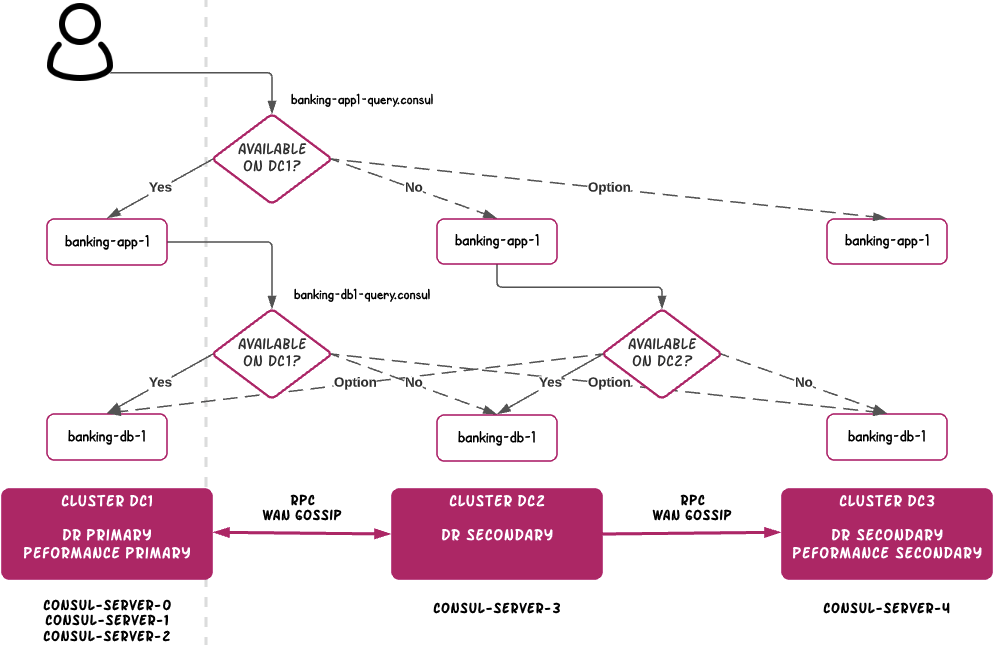

## Prepared query introduction

* Prepared queries are objects that are defined at the datacenter level.
* Only need to be created once and are stored on the Consul servers.
* Can be invoked by applications to perform the query and get the latest results.

Here's an example request to create a prepared query:

```shell
$ curl http://127.0.0.1:8500/v1/query \
    --request POST \
    --data @- << EOF
{
  "Name": "banking-app",
  "Service": {
    "Service": "banking-app",
    "Tags": ["v1.2.3"]
  }
}
EOF
```

This creates a prepared query called "`banking-app`".
- Does a lookup for all instances of the "`banking-app`" service with the tag "`v1.2.3`".
- This policy could be used to control which version of a "`banking-app`" applications should be using in a centralized way.
- By [updating this prepared query](https://www.consul.io/api/query.html#update-prepared-query) to look for the tag "`v1.2.4`" applications could start to find the newer version of the service without having to reconfigure anything.

Applications can make use of this query in two ways.

1. Since we gave the prepared query a name, they can simply do a DNS lookup for "`banking-app.query.consul`" instead of "`banking-app.service.consul`". Now with the prepared query, there's the additional filter policy working behind the scenes that the application doesn't have to know about.

1. Queries can also be executed using the [prepared query execute API](https://www.consul.io/api/query.html#execute-prepared-query) for applications that integrate with Consul's APIs directly.

## Failover policy types

Using the techniques in this section you will develop prepared queries with failover policies where simply changing application configurations to look up "`banking-app.query.consul`" instead of "`banking-app.service.consul`" via DNS will result in automatic geo failover to the next closest [federated](https://learn.hashicorp.com/tutorials/consul/federation-gossip-wan) Consul datacenters, in order of increasing network round trip time.

Failover is just another policy choice for a prepared query, it works in the same manner as the previous example and is similarly transparent to applications. The failover policy is configured using the `Failover` structure, which contains two fields, both of which are optional, and determine what happens if no healthy nodes are available in the local datacenter when the query is executed.

- `NearestN` `(int: 0)` - Specifies that the query will be forwarded to up to `NearestN` other datacenters based on their estimated network round trip time using [network coordinates](https://www.consul.io/docs/internals/coordinates.html).

- `Datacenters` `(array<string>: nil)` - Specifies a fixed list of remote datacenters to forward the query to if there are no healthy nodes in the local datacenter.
    - **NOTE**: Datacenters are queried in the order given in the list.

The following examples use those fields to implement different geo failover policies methods.

## Register a Service

Register a service in each cluster. For our purposes it does not need to be real.

In [ ]:
for node_number in 0 3 4; do
docker exec -i consul-server-${node_number} sh <<EOM
printf "#==> create service definition.\n"
cat > /tmp/consul_service.json <<EOF
{
    "service": {
        "id": "banking1",
        "name": "banking-app",
        "Tags": ["primary", "v1.2.3"],
        "Address": "10.${node_number}.0.88",
        "Port": 8000,
        "Meta": {
            "banking_version": "4.0"
        },
        "enable_tag_override": false,
        "Weights": {
            "Passing": 10,
            "Warning": 1
        }
    }
}
EOF
#   "Check": {
#     "DeregisterCriticalServiceAfter": "90m",
#     "Args": ["/usr/local/bin/check_redis.py"],
#     "Interval": "10s",
#     "Timeout": "5s"
#   },
# }
# EOF

printf "\n#==> register service.\n"
consul services register /tmp/consul_service.json
# curl \
#     --request PUT \
#     --data @/tmp/consul_service.json \
#     http://127.0.0.1:8500/v1/agent/service/register #?replace-existing-checks=true
EOM
done

In [ ]:
curl \
    --request PUT \
    http://127.0.0.1:8500/v1/agent/service/deregister/redis1

## Static policy

A static failover policy includes a fixed list of datacenters to contact once there are no healthy instances in the local datacenter.

List your zones.

In [ ]:
curl -s http://localhost:8500/v1/catalog/datacenters | jq -r .[]

<br>Set them for the `CONSUL_DC*` variables below.

In [ ]:
export CONSUL_DC=zone1 CONSUL_DC_2=zone2 CONSUL_DC_3=zone3
printf "$CONSUL_DC $CONSUL_DC_2 $CONSUL_DC_3"

Here's the example from the introduction, expanded with a static failover policy:

In [ ]:
curl http://127.0.0.1:8500/v1/query \
    --request POST \
    --data @- << EOF
{
  "Name": "banking-app",
  "Service": {
    "Service": "banking-app",
    "Tags": ["v1.2.3"],
    "Failover": {
      "Datacenters": ["${CONSUL_DC}", "${CONSUL_DC_2}", "${CONSUL_DC_3}"]
    }
  }
}
EOF

When this query is executed, such as with a DNS lookup to "`banking-app.query.consul`", the following actions will occur:

1. Consul servers in the local datacenter will attempt to find healthy instances of the "banking-app" service with the required tag.
1. If none are available locally, the Consul servers will make an RPC request to the Consul servers in "dc2" to perform the query there.
1. If none are available in "dc2", then an RPC will be made to the Consul servers in "dc3" to perform the query there.
1. Finally an error will be returned if none of these datacenters had any instances available.

### Verify Prepared Queries were added to the system

In [ ]:
PREPARED_QUERIES=$(curl -s http://127.0.0.1:8500/v1/query | jq ".") \
  && echo $PREPARED_QUERIES | jq -c

In [ ]:
curl -s http://127.0.0.1:8500/v1/query | jq -r '.[] | select(.Name | contains("banking-app"))|.ID'

In [ ]:
json='[{"genre":"deep house"}, {"genre": "progressive house"}, {"genre": "dubstep"}]'
echo "$json" | jq -c '.[] | select(.genre | contains("house"))'

In [ ]:
docker exec -i consul-server-0 sh <<"EOF"
apk add bind-tools
dig @consul-server-0 -p 8600 banking-app.query.consul srv | grep -A2 SECTION
EOF

### Deregister service from DC1

Deregister service from DC1 to simulate the service not being available.

In [ ]:
consul services deregister -id banking1
printf "\n#==> Confirm that the banking service is gone\n"
consul catalog services

<br>Verify DNS answer is now for `DC2`

In [ ]:
dig @127.0.0.1 -p 8600 banking-app.query.consul srv | grep -A2 SECTION

<br>Add service back in.

In [ ]:
for node_number in 0; do
docker exec -i consul-server-${node_number} sh <<EOM
printf "\n#==> register service.\n"
consul services register /tmp/consul_service.json #\
#    http://127.0.0.1:8500/v1/agent/service/register #?replace-existing-checks=true
EOM
done

Verify answer is now for `DC1` again.

In [ ]:
dig @127.0.0.1 -p 8600 banking-app.query.consul srv

## Dynamic policy

In a complex federated environment with many Consul datacenters, it can be cumbersome to set static failover policies, so Consul offers a dynamic option based on Consul's [network coordinate](https://www.consul.io/docs/internals/coordinates.html) subsystem.

Consul continuously maintains an estimate of the network round trip time from the local datacenter to the servers in other datacenters it is federated with. Each server uses the median round trip time from itself to the servers in the remote datacenter. This means that failover can simply try other remote datacenters in order of increasing network round trip time, and if datacenters come and go, or experience network issues, this order will adjust automatically.

Here's the example from the introduction, expanded with a dynamic failover policy:

```shell
$ curl http://127.0.0.1:8500/v1/query \
    --request POST \
    --data @- << EOF
{
  "Name": "banking-app",
  "Service": {
    "Service": "banking-app",
    "Tags": ["v1.2.3"],
    "Failover": {
      "NearestN": 2
    }
  }
}
EOF
```

This example updates an existing query. If this is a new query then delete the values after `/v1/query/`.

In [ ]:
BANKING_APP_ID=$(curl -s http://127.0.0.1:8500/v1/query | jq -r '.[] | select(.Name | contains("banking-app"))|.ID')
curl http://127.0.0.1:8500/v1/query/${BANKING_APP_ID} \
    --request PUT \
    --data @- << EOF
{
  "Name": "banking-app",
  "Service": {
    "Service": "banking-app",
    "Tags": ["v1.2.3"],
    "Failover": {
      "NearestN": 2
    }
  }
}
EOF

This query is resolved in a similar fashion to the previous example, except the choice of "`dc1`" or "`dc2`", or possibly some other datacenter, is made automatically.

* `"NearestN": 2` - Specifies that the query will be forwarded to up to `NearestN` other datacenters based on their estimated network round trip time using Network Coordinates from the WAN gossip pool.
    * The median round trip time from the server handling the query to the servers in the remote datacenter is used to determine the priority.

### Verify Dynamic Prepared Queries

See the RTT between two datacenters.

In [ ]:
for i in {1..3};do
consul rtt -wan consul-server-0.${CONSUL_DC} consul-server-3.${CONSUL_DC_2}
consul rtt -wan consul-server-0.${CONSUL_DC} consul-server-4.${CONSUL_DC_3}
done

<br>
Confirm that the query returns the local result (DC1).

In [ ]:
docker exec -i consul-server-0 sh <<"EOF"
# apk add bind-tools
dig @consul-server-0 -p 8600 banking-app.query.consul srv | grep -A2 SECTION
EOF

Deregister service from DC1

In [ ]:
consul services deregister -id banking1
printf "\n#==> Confirm that the banking service is gone\n"
consul catalog services

<br>Verify DNS answer now points to `DC2` or `DC3`.

In [ ]:
dig @127.0.0.1 -p 8600 banking-app.query.consul srv | grep -A2 SECTION

Run the following command in a different terminal.

```shell
watch "dig @127.0.0.1 -p 8600 banking-app.query.consul srv | grep -A2 SECTION"
```

Deregister service from the zone in `watch` results. Check [diagram](#Diagram) to see which server belongs to which zone.

In [ ]:
docker exec -i consul-server-3 sh <<EOF
consul services deregister -id banking1
printf "\n#==> Confirm that the banking service is gone\n"
consul catalog services
EOF

**NOTE**: The DNS answer for `dig` should now be for the last zone.

Deregister service from last zone in `watch` results

In [ ]:
docker exec -i consul-server-4 sh <<EOF
printf "\n#==> List current services\n"
consul catalog services
printf "\n#==> Deregister services\n"
consul services deregister -id banking1
printf "\n#==> Confirm that the banking service is gone\n"
consul catalog services
EOF

<br>**NOTE**: The DNS answer should now be unavailable.

Add service back in. Starting from zone 3 to zone 1. **NOTE**:The DNS answers should change accordingly.

In [ ]:
for node_number in 4 3 0; do
docker exec -i consul-server-${node_number} sh <<EOM
printf "\n#==> register service.\n"
consul services register /tmp/consul_service.json
sleep 3
EOM
done

<br>Verify answer is now for `DC1` again.

```shell
Every 1.0s: dig @127.0.0.1 -p 8600 banking-app.query.consul srv | grep -A2 SECTION -h

;; OPT PSEUDOSECTION:
; EDNS: version: 0, flags:; udp: 4096
;; QUESTION SECTION:
;banking-app.query.consul.      IN      SRV

;; ANSWER SECTION:
banking-app.query.consul. 0     IN      SRV     1 10 8000 7f000001.addr.zone1.consul.

;; ADDITIONAL SECTION:
7f000001.addr.zone1.consul. 0   IN      A       127.0.0.1
consul-server-0.node.zone1.consul. 0 IN TXT     "consul-network-segment="
```

In [ ]:
dig @127.0.0.1 -p 8600 banking-app.query.consul srv

## Prepared query template

For datacenters with many services, it can be challenging to define a geo failover policy for each service. To relieve this challenge, Consul provides a [prepared query template](https://www.consul.io/api/query.html#prepared-query-templates) that allows one prepared query to apply to many, and even all, services.

Templates can match on prefixes or use full regular expressions to determine which services they match.

Below is an example request to create a prepared query template that applies a catch-all policy of dynamic geo failover to all services accessed by query lookup (`*.query.consul`). By specifying the `name_prefix_match` type and an empty name, this query template's policy will be applied to any name (`<name>.query.consul`) that doesn't [match a higher-precedence query](https://www.consul.io/api-docs/query#type).

```shell
$ curl http://127.0.0.1:8500/v1/query \
    --request POST \
    --data @- << EOF
{
  "Name": "",
  "Template": {
    "Type": "name_prefix_match"
  },
  "Service": {
    "Service": "${name.full}",
    "Failover": {
      "NearestN": 2
    }
  }
}
EOF
```

This example updates an existing query. If this is a new query then delete the parameters after `/v1/query/`.

In [ ]:
BANKING_APP_ID=$(curl -s http://127.0.0.1:8500/v1/query | jq -r '.[] | select(.Name | contains("banking-app"))|.ID')
curl http://127.0.0.1:8500/v1/query/${BANKING_APP_ID} \
    --request PUT \
    --data @- << EOF
{
  "Name": "",
  "Template": {
    "Type": "name_prefix_match"
  },
  "Service": {
    "Service": "\${name.full}",
    "Failover": {
      "NearestN": 2,
      "Datacenters": ["${CONSUL_DC}","${CONSUL_DC_2}","${CONSUL_DC_3}"]
    }
  }
}
EOF

> **Note**: If multiple queries are registered, the most specific one will be selected, so it's possible to have a template like this as a catch-all, and then apply more specific policies to certain services.

With this one prepared query template in place, simply changing application configurations to look up `banking-app.query.consul` instead of `banking-app.service.consul` via DNS will result in automatic geo failover to the next closest federated Consul datacenters, in order of increasing network round trip time.

Verify query was added to the system.

In [ ]:
curl -s http://127.0.0.1:8500/v1/query | jq -r '.[] | {ID: .ID}, .Template, .Service'

Create a new service called `banking-2`.

In [ ]:
for node_number in 0 3 4; do
docker exec -i consul-server-${node_number} sh <<EOM
printf "#==> create service definition.\n"
cat > /tmp/consul_service_2.json <<EOF
{
    "service": {
        "id": "banking2",
        "name": "banking-app-2",
        "Tags": ["primary", "v1.2.3"],
        "Address": "127.0.0.1",
        "Port": 8000,
        "Meta": {
            "banking_version": "4.0"
        },
        "enable_tag_override": false,
        "Weights": {
            "Passing": 10,
            "Warning": 1
        }
    }
}
EOF

printf "\n#==> register service.\n"
consul services register /tmp/consul_service_2.json
EOM
done

<br>Confirm the new `banking-app-2` shows up in the catalog.

In [ ]:
consul catalog services

### Verify Prepared Query Templates

In [ ]:
dig @127.0.0.1 -p 8600 banking-app-2.query.consul srv | grep -A2 SECTION

**NOTE**: Even though you did not create a prepared query for `banking-app-2`, the template caught the request and responded accordingly.

Run the following command in a different terminal.

```shell
watch "dig @127.0.0.1 -p 8600 banking-app-2.query.consul srv | grep -A2 SECTION"
```

Deregister service from DC1

In [ ]:
consul services deregister -id=banking2

Verify answer is now for `DC2` or `DC3`

In [ ]:
dig @127.0.0.1 -p 8600 banking-app-2.query.consul srv | grep -A2 SECTION

Sample Output
```shell
...
;; QUESTION SECTION:
;banking-app-2.query.consul.	IN	SRV

;; ANSWER SECTION:
banking-app-2.query.consul. 0	IN	SRV	1 10 8000 7f000001.addr.zone2.consul.

;; ADDITIONAL SECTION:
7f000001.addr.zone2.consul. 0	IN	A	127.0.0.1
...
```

Deregister service from cluster currently in answer.
* DC1 = consul-server0
* DC2 = consul-server3
* DC3 = consul-server4

In [ ]:
docker exec consul-server-3 consul services deregister -id=banking2

Verify answer is now for remaining cluster.

In [ ]:
dig @127.0.0.1 -p 8600 banking-app-2.query.consul srv | grep -A2 "ANSWER SECTION"

Sample Output
```shell
;; ANSWER SECTION:
banking-app-2.query.consul. 0	IN	SRV	1 10 8000 7f000001.addr.zone3.consul.
```

Deregister service from cluster currently in answer.
* DC1 = consul-server0
* DC2 = consul-server3
* DC3 = consul-server4

In [ ]:
docker exec consul-server-4 consul services deregister -id=banking2

Verify answer is now unavailable.

In [ ]:
dig @127.0.0.1 -p 8600 banking-app-2.query.consul srv | grep -A2 "ANSWER SECTION" || true

Add service back in and check results. We will add to non-local DC's first.

In [ ]:
for node_number in 4 3 0; do
docker exec -i consul-server-${node_number} sh <<EOM
printf "\n#==> register service.\n"
consul services register /tmp/consul_service_2.json
sleep 3
EOM

printf "\n#==> Check DNS Results.\n"
dig @127.0.0.1 -p 8600 banking-app-2.query.consul srv | grep -A2 "ANSWER SECTION"
done

Verify answer is now for DC1 again.

In [ ]:
dig @127.0.0.1 -p 8600 banking-app-2.query.consul srv | grep -A2 "ANSWER SECTION"

## Delete prepared query

In [ ]:
curl -s http://127.0.0.1:8500/v1/query/$(echo $PREPARED_QUERIES | jq -r .[0].ID) -X DELETE

## Next steps

In this tutorial, you learned how to use prepared queries for failover when integrating Consul with other applications. You can now configure your policies to failover to the nearest federated datacenter or to a list of secondary datacenters. You can also create a prepared query template which will help you reduce some complexity of creating policies for each individual service.

## Resources

* https://learn.hashicorp.com/tutorials/consul/automate-geo-failover
* https://www.consul.io/api-docs/query
* https://www.devtech101.com/2019/01/30/updated-using-consul-for-service-discovery-in-multiple-data-centers-version-1-4-part-2/
* https://www.consul.io/docs/architecture/coordinates
